In [17]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano
import theano.tensor as tt


random_state = np.random.RandomState(42)

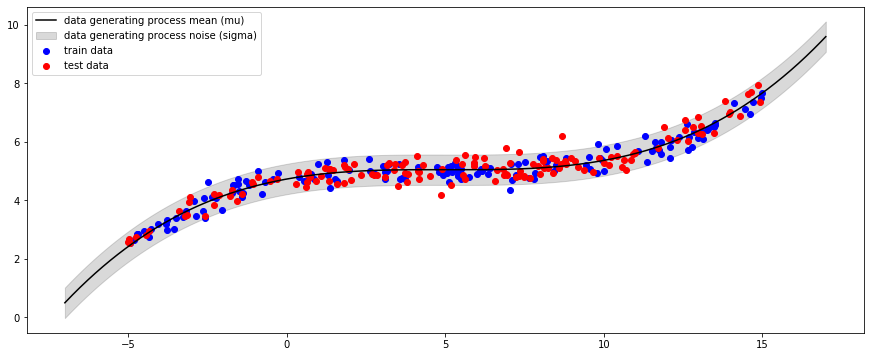

In [18]:
# make data

def fake_model(x):
    return x**3 - x

num_samples = 150
scale_factor = 100

x_train = np.random.uniform(-10, 10, num_samples)
x_train = x_train.reshape(-1, 1)
y_train = fake_model(x_train) + random_state.normal(0, 100, num_samples).reshape(-1, 1) 

x_test = np.random.uniform(-10, 10, num_samples)
x_test = x_test.reshape(-1, 1)
y_test = fake_model(x_test) + random_state.normal(0, 100, num_samples).reshape(-1, 1)

feature_space = np.linspace(-12, 12, 1000).reshape(-1, 1)
y_true = fake_model(feature_space)

# scale data (best practice for good results)

y_train_mean = y_train.mean()
y_train_std = y_train.std()

scale = 1.0
y_train = scale * (y_train - y_train_mean) / y_train_std
y_test = scale * (y_test - y_train_mean) / y_train_std
y_true = scale * (y_true - y_train_mean) / y_train_std

x_train = x_train.astype("float32") + 5
y_train = y_train.astype("float32") + 5
x_test = x_test.astype("float32") + 5
y_test = y_test.astype("float32") + 5
feature_space = feature_space.astype("float32") + 5
y_true = y_true.astype("float32") + 5

# plot data

train_color = "b"
test_color = "r"

plt.figure(figsize=(15, 6))
plt.plot(feature_space[:, 0], y_true, c="k", label="data generating process mean (mu)")
plt.fill_between(feature_space[:, 0],
    y_true[:, 0] + 1.96 * scale * 100 / y_train_std, 
    y_true[:, 0] - 1.96 * scale * 100 / y_train_std,
    color="k", alpha=0.15, label="data generating process noise (sigma)"
)
plt.scatter(x_train[:, 0], y_train[:, 0], c=train_color, label="train data")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.legend()
plt.show()

In [54]:
X = x_train.T
Y = y_train

ann_input = theano.shared(X)
ann_output = theano.shared(Y)

n_hidden = 5
    
# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden).astype(theano.config.floatX)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                     weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                     weights_1_2))
    act_out = pm.math.dot(act_2, weights_2_out)
        
    out = pm.Normal('out', mu=act_out, sigma=1.0, observed=ann_output)

In [55]:
with neural_network:
    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
Sampling 4 chains, 183 divergences: 100%|██████████| 6000/6000 [03:35<00:00, 27.79draws/s]
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparam

In [56]:
ppc = pm.sample_ppc(trace, model=neural_network, samples=100)

/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:01<00:00, 93.93it/s]


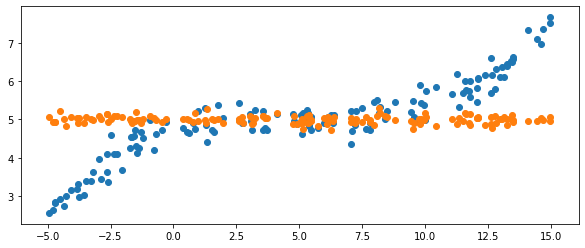

In [57]:
y_pred = ppc["out"].mean(axis=0)

plt.figure(figsize=(10, 4))
plt.scatter(x_train[:,0], y_train[:, 0])
plt.scatter(x_train[:,0], y_pred[:, 0])
plt.show()

In [47]:
ann_input.set_value(x_test.T)
ann_output.set_value(y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=True)

/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
100%|██████████| 500/500 [00:05<00:00, 99.08it/s] 
